<a href="https://colab.research.google.com/github/BandaAkshitha/Natural-Language-Processing/blob/main/NLP_Lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLTK

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk
from collections import Counter
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
df = pd.read_csv(
    '/content/arxiv_data.csv',
    engine='python',
    nrows=1000
)

# Select CS / AI domain
df = df[df['terms'].str.contains('cs', na=False)]

df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


Text Cleaning

In [ ]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = text.lower()

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text
df['processed_summaries'] = df['summaries'].apply(preprocess_text)

Tokenization

In [ ]:
df['tokenized_summaries'] = df['processed_summaries'].apply(
    lambda x: word_tokenize(x)
)

Stopword Removal

In [ ]:
stop_words = set(stopwords.words('english'))

df['filtered_summaries'] = df['tokenized_summaries'].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)

Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

df['lemmatized_summaries'] = df['filtered_summaries'].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)

Rejoin Tokens into Clean Text

In [ ]:
df['clean_summaries'] = df['lemmatized_summaries'].apply(
    lambda tokens: " ".join(tokens)
)

Tokenize Essay / Abstract Text

In [ ]:
tokens = word_tokenize(df['clean_summaries'].iloc[0])
tokens[:20]

['stereo',
 'matching',
 'one',
 'widely',
 'used',
 'technique',
 'inferring',
 'depth',
 'stereo',
 'image',
 'owing',
 'robustness',
 'speed',
 'become',
 'one',
 'major',
 'topic',
 'research',
 'since',
 'find']

Extract Frequent Noun Phrases

In [ ]:
grammar = "NP: {<JJ>*<NN.*>+}"
chunk_parser = nltk.RegexpParser(grammar)

noun_phrases = []

for text in df['clean_summaries'].head(50):
    words = word_tokenize(text)
    tagged = pos_tag(words)
    tree = chunk_parser.parse(tagged)

    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            noun_phrases.append(
                " ".join(word for word, tag in subtree.leaves())
            )

Top Noun Phrases

In [ ]:
np_freq = Counter(noun_phrases)
top_nps = np_freq.most_common(10)
top_nps

[('method', 14),
 ('medical image segmentation', 13),
 ('data', 10),
 ('image', 10),
 ('approach', 8),
 ('model', 7),
 ('datasets', 7),
 ('deep reinforcement', 7),
 ('framework', 6),
 ('work', 6)]

Visualize Top Noun Phrases

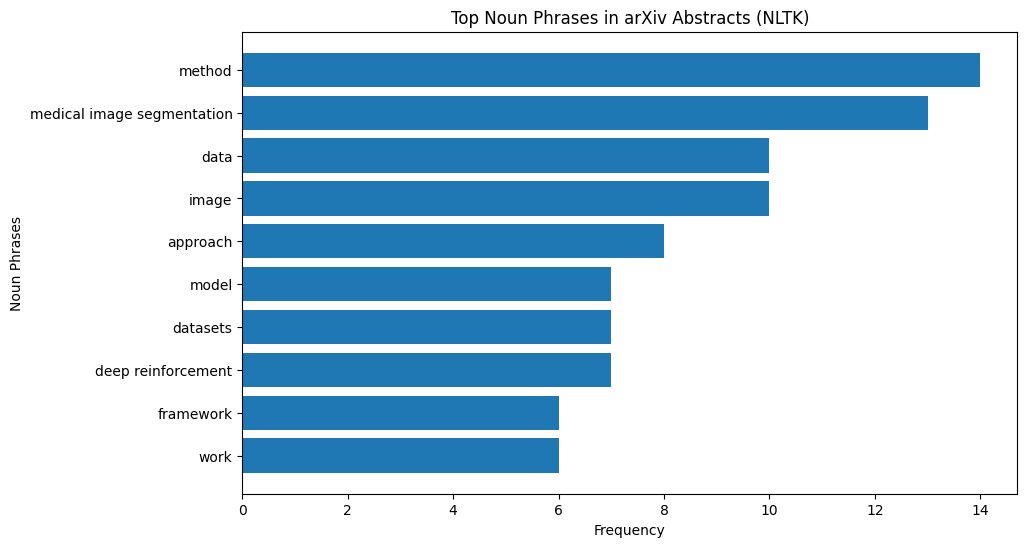

In [ ]:
phrases = [p[0] for p in top_nps]
counts = [p[1] for p in top_nps]

plt.figure(figsize=(10, 6))
plt.barh(phrases, counts)
plt.xlabel("Frequency")
plt.ylabel("Noun Phrases")
plt.title("Top Noun Phrases in arXiv Abstracts (NLTK)")
plt.gca().invert_yaxis()
plt.show()

Named Entity Recognition

In [9]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk
from collections import Counter

# Ensure NLTK data is downloaded (if not already)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix LookupError
nltk.download('averaged_perceptron_tagger_eng', quiet=True) # Explicitly added this download
nltk.download('maxent_ne_chunker_tab', quiet=True) # Added to fix LookupError

# --- Start: Ensure df and clean_summaries are defined for this cell ---
# Code from mHZlnLDF0zfq (Load df and filter for CS/AI domain)
df = pd.read_csv(
    '/content/arxiv_data.csv',
    engine='python',
    nrows=1000
)
df = df[df['terms'].str.contains('cs', na=False)]

# Code from tJ9EBCz1GxZ (Define preprocess_text and apply)
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = text.lower()
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['processed_summaries'] = df['summaries'].apply(preprocess_text)

# Code from CjG-8oBO1Qvb (Tokenize summaries)
df['tokenized_summaries'] = df['processed_summaries'].apply(
    lambda x: word_tokenize(x)
)

# Code from 7BMbKk7U1Wt2 (Remove stopwords)
stop_words = set(stopwords.words('english'))
df['filtered_summaries'] = df['tokenized_summaries'].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)

# Code from qUZIKVf81cny (Lemmatize words)
lemmatizer = WordNetLemmatizer()
df['lemmatized_summaries'] = df['filtered_summaries'].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)

# Code from TazDYsWF1i-s (Rejoin tokens into clean text)
df['clean_summaries'] = df['lemmatized_summaries'].apply(
    lambda tokens: " ".join(tokens)
)
# --- End: Ensure df and clean_summaries are defined for this cell ---

entities = []

# Define abstracts using the clean_summaries column from NLTK preprocessing
abstracts = df['clean_summaries'].head(50).tolist()

for text in abstracts:
    words = word_tokenize(text)
    tags = nltk.pos_tag(words)
    chunks = nltk.ne_chunk(tags)

    for chunk in chunks:
        if hasattr(chunk, 'label'):
            entity = " ".join(c[0] for c in chunk)
            entities.append(chunk.label())

Entity Frequency

In [10]:
entity_freq = Counter(entities)
entity_freq

Counter()

Visualize Entity Frequency Chart

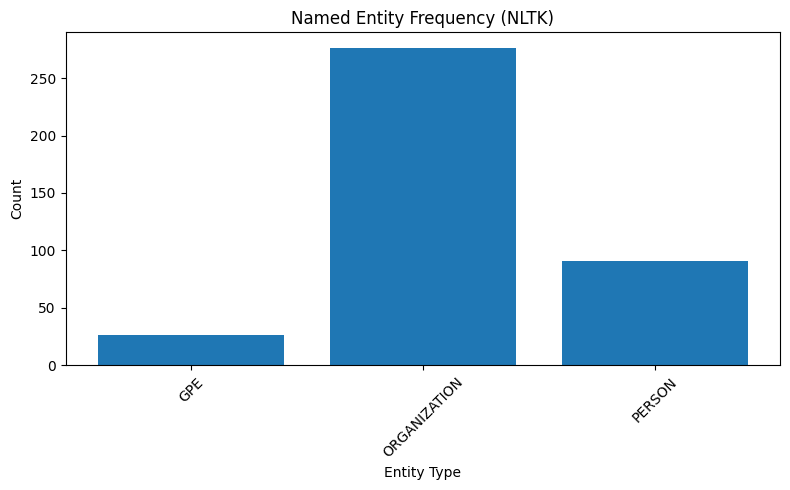

In [12]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk import word_tokenize, pos_tag, ne_chunk

# Combine multiple abstracts to increase entity detection
text = " ".join(df['summaries'].dropna().head(100))

# NLTK Named Entity Recognition pipeline
tokens = word_tokenize(text)
pos_tags = pos_tag(tokens)
chunked = ne_chunk(pos_tags)

# Extract entity labels
entity_labels = []
for chunk in chunked:
    if hasattr(chunk, 'label'):
        entity_labels.append(chunk.label())

# Count entity types
entity_freq = Counter(entity_labels)

# Plot entity frequency
plt.figure(figsize=(8, 5))
plt.bar(entity_freq.keys(), entity_freq.values())
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Named Entity Frequency (NLTK)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

WordCloud

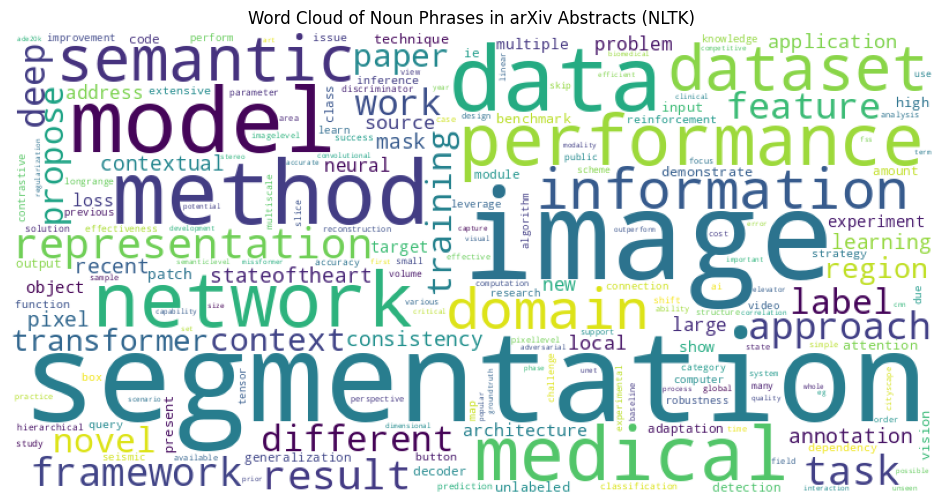

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
np_freq = Counter(noun_phrases)

# Convert noun phrases into single string (repeat by frequency)
text = " ".join([phrase for phrase, freq in np_freq.items() for _ in range(freq)])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False
).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud of Noun Phrases in arXiv Abstracts (NLTK)")
plt.show()

SPACY

In [ ]:
import pandas as pd
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df = pd.read_csv(
    '/content/arxiv_data.csv',
    engine='python',
    nrows=1000
)

df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


TEXT PREPROCESSING

In [ ]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
    df['processed_summaries'] = df['summaries'].apply(preprocess_text)

WORD TOKENIZATION

In [ ]:
df['processed_summaries'] = df['summaries'].apply(preprocess_text)
df['tokenized_summaries'] = df['processed_summaries'].apply(
    lambda x: word_tokenize(x)
)

STOPWORD REMOVAL

In [ ]:
stop_words = set(stopwords.words('english'))

df['filtered_summaries'] = df['tokenized_summaries'].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)

LEMMATIZATION

In [ ]:
lemmatizer = WordNetLemmatizer()

df['lemmatized_summaries'] = df['filtered_summaries'].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)

Rejoin words

In [ ]:
df['clean_summaries'] = df['lemmatized_summaries'].apply(
    lambda tokens: " ".join(tokens)
)

Unified NLTK Preprocessing Pipeline

In [ ]:
def nltk_preprocessing_pipeline(text):
    if pd.isna(text):
        return ""

    text = preprocess_text(text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)
df['clean_summaries_pipeline'] = df['summaries'].apply(
    nltk_preprocessing_pipeline
)

Install and Load spaCy

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Select Domain and Process Abstracts

In [ ]:
df_cs = df[df['terms'].str.contains('cs', na=False)]
abstracts = df_cs['clean_summaries'].head(50).tolist()

docs = [nlp(text) for text in abstracts]

Tokenize Essay / Abstract Text

In [ ]:
tokens = [
    token.text
    for token in docs[0]
    if not token.is_stop and not token.is_punct
]

tokens[:20]

['stereo',
 'matching',
 'widely',
 'technique',
 'inferring',
 'depth',
 'stereo',
 'image',
 'owing',
 'robustness',
 'speed',
 'major',
 'topic',
 'research',
 'find',
 'application',
 'autonomous',
 'driving',
 'robotic',
 'navigation']

Extract Frequent Noun Phrases

In [ ]:
noun_phrases = []

for doc in docs:
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text.lower())

np_freq = Counter(noun_phrases)
top_nps = np_freq.most_common(10)


 Visualize Top Noun Phrases

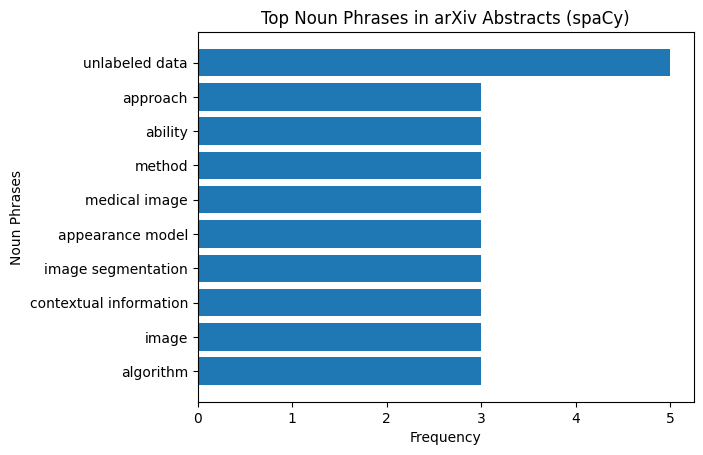

In [ ]:
phrases = [p[0] for p in top_nps]
counts = [p[1] for p in top_nps]

plt.barh(phrases, counts)
plt.xlabel("Frequency")
plt.ylabel("Noun Phrases")
plt.title("Top Noun Phrases in arXiv Abstracts (spaCy)")
plt.gca().invert_yaxis()
plt.show()

Named Entity Recognition (NER)

In [ ]:
entities = []

for doc in docs:
    for ent in doc.ents:
        if ent.label_ in ["ORG", "DATE", "PRODUCT", "GPE"]:
            entities.append(ent.label_)

entity_freq = Counter(entities)

Visualize Entity Frequency Chart

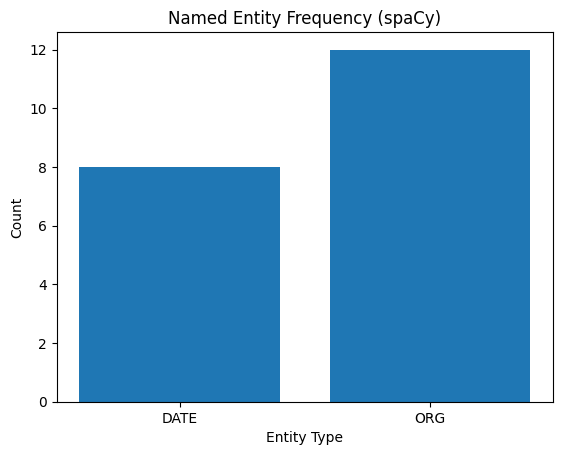

In [ ]:
plt.bar(entity_freq.keys(), entity_freq.values())
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Named Entity Frequency (spaCy)")
plt.show()

Rule-Based Technical Term Extraction (spaCy Matcher)

In [ ]:
matcher = Matcher(nlp.vocab)

pattern1 = [{"POS": "ADJ"}, {"POS": "NOUN"}]
pattern2 = [{"POS": "NOUN"}, {"POS": "NOUN"}]

matcher.add("TECH_TERMS", [pattern1, pattern2])
matched_terms = []

for doc in docs:
    matches = matcher(doc)
    for match_id, start, end in matches:
        matched_terms.append(doc[start:end].text.lower())

Counter(matched_terms).most_common(10)

[('image segmentation', 68),
 ('medical image', 37),
 ('semantic segmentation', 18),
 ('segmentation task', 16),
 ('contextual information', 14),
 ('neural network', 12),
 ('unlabeled data', 10),
 ('segmentation model', 9),
 ('training data', 8),
 ('semantic image', 8)]

WHOLE CODE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


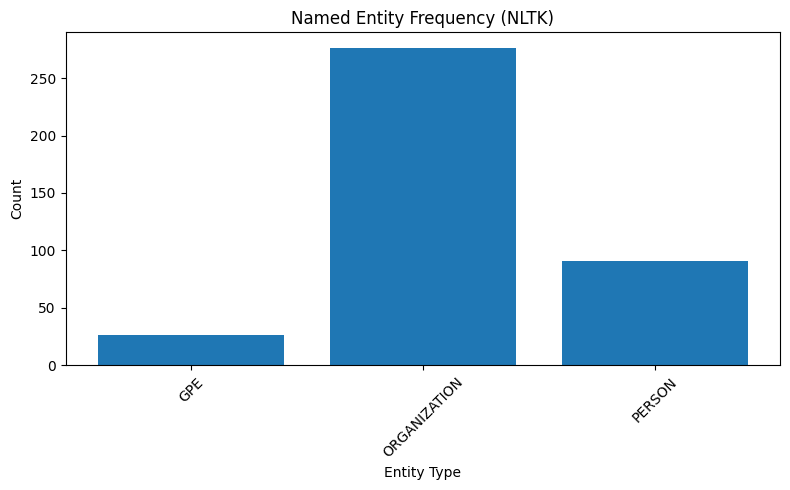

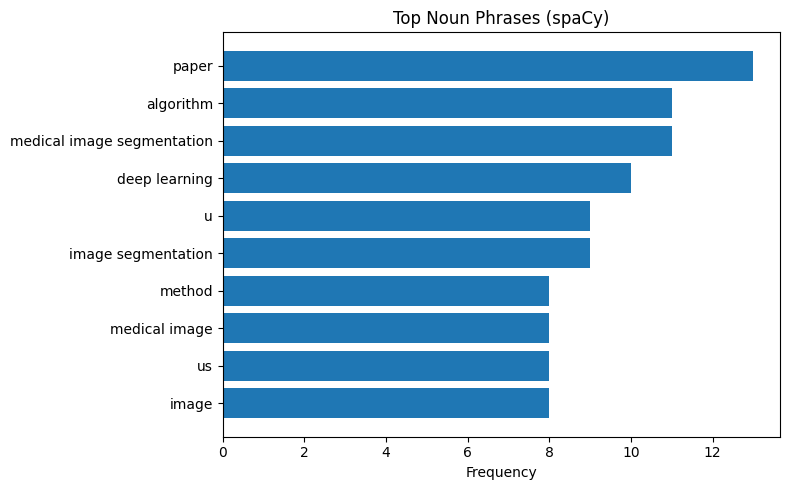

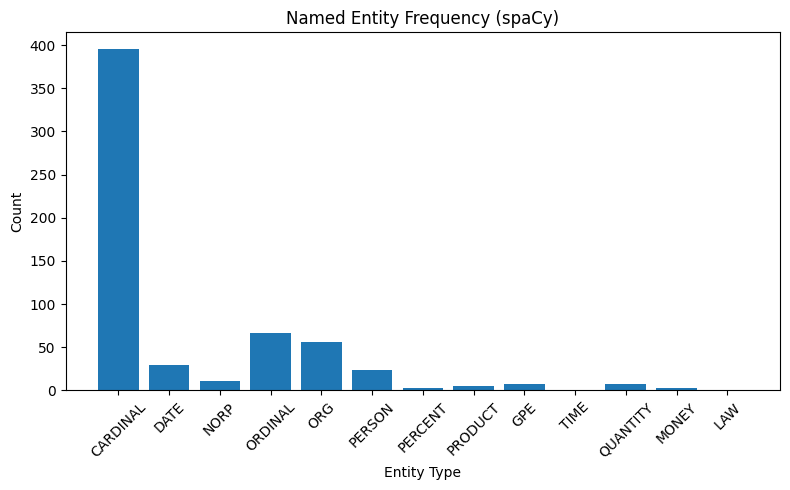


Top Noun Phrases (spaCy):
paper : 13
algorithm : 11
medical image segmentation : 11
deep learning : 10
u : 9
image segmentation : 9
method : 8
medical image : 8
us : 8
image : 8

Top Technical Terms (spaCy Matcher):
medical image : 137
semantic segmentation : 57
deep learning : 43
neural network : 37
extensive experiment : 20
experimental result : 20
long range : 20
contextual information : 20
real world : 16
contrastive learning : 16


In [13]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter

# NLTK imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk

# spaCy imports
import spacy
from spacy.matcher import Matcher

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 2. LOAD DATASET

df = pd.read_csv("arxiv_data.csv", engine="python", nrows=1000)
df = df[['summaries']].dropna()

# 3. NLTK TEXT PREPROCESSING PIPELINE

def nltk_preprocessing_pipeline(text):
    # Remove URLs, HTML, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|<.*?>|@\w+|#\w+", " ", text)
    # Lowercase
    text = text.lower()
    # Remove emojis & special characters
    text = re.sub(r"[^\w\s]", " ", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)


# Apply NLTK pipeline
df["clean_summaries"] = df["summaries"].apply(nltk_preprocessing_pipeline)


# 4. NLTK NAMED ENTITY RECOGNITION

combined_text = " ".join(df["summaries"].head(100))

tokens = word_tokenize(combined_text)
pos_tags = pos_tag(tokens)
chunked = ne_chunk(pos_tags)

nltk_entities = []
for chunk in chunked:
    if hasattr(chunk, "label"):
        nltk_entities.append(chunk.label())

nltk_entity_freq = Counter(nltk_entities)


# 5. NLTK ENTITY FREQUENCY VISUALIZATION

plt.figure(figsize=(8, 5))
plt.bar(nltk_entity_freq.keys(), nltk_entity_freq.values())
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Named Entity Frequency (NLTK)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. spaCy PIPELINE PROCESSING

docs = list(nlp.pipe(df["clean_summaries"].head(200)))


# 7. spaCy NOUN PHRASE EXTRACTION

noun_phrases = []
for doc in docs:
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text.lower())

noun_phrase_freq = Counter(noun_phrases).most_common(10)


# 8. spaCy NOUN PHRASE VISUALIZATION

labels, values = zip(*noun_phrase_freq)

plt.figure(figsize=(8, 5))
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.title("Top Noun Phrases (spaCy)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 9. spaCy NAMED ENTITY RECOGNITION

spacy_entities = []
for doc in docs:
    for ent in doc.ents:
        spacy_entities.append(ent.label_)

spacy_entity_freq = Counter(spacy_entities)


plt.figure(figsize=(8, 5))
plt.bar(spacy_entity_freq.keys(), spacy_entity_freq.values())
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Named Entity Frequency (spaCy)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 11. spaCy MATCHER FOR TECHNICAL TERMS

matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "ADJ"},
    {"POS": "NOUN"}
]

matcher.add("TECH_TERM", [pattern])

matched_terms = []
for doc in docs:
    matches = matcher(doc)
    for match_id, start, end in matches:
        matched_terms.append(doc[start:end].text.lower())

tech_term_freq = Counter(matched_terms).most_common(10)

# 12. OUTPUT RESULTS

print("\nTop Noun Phrases (spaCy):")
for term, freq in noun_phrase_freq:
    print(term, ":", freq)

print("\nTop Technical Terms (spaCy Matcher):")
for term, freq in tech_term_freq:
    print(term, ":", freq)
